In [1]:
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm.auto import tqdm
import glob

In [2]:

use_gpu = True if torch.cuda.is_available() else False
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True

In [3]:
# download dataset
# http://vision.cs.utexas.edu/projects/finegrained/utzap50k/

In [4]:
class MyShoeDataset(Dataset):
    def __init__(self, src_dir='ut-zap50k-images', image_size=64):
        self.transform = transforms.Compose([transforms.Resize((image_size,image_size), Image.LANCZOS),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

        self.img_paths = []
        for file in glob.glob(src_dir+"/*/*/*/*.jpg"):
            with Image.open(file) as image:
                if(len(np.array(image).shape) == 3 and np.array(image).shape[-1] == 3):
                    self.img_paths.append(file)
                else:
                    print(np.array(image).shape)
                
                # debug use
                if len(self.img_paths) > 100:
                    break
                
    def __getitem__(self, index):
        with Image.open(self.img_paths[index]) as image:
            out_image = self.transform(image)
        return out_image
    
    def __len__(self):
        return len(self.img_paths)

In [5]:
dataset = MyShoeDataset()

In [6]:
# download pretrained model
# gdown https://drive.google.com/u/0/uc?id=1c55XIkKG65OYar7JjJG7pLt6JTGWCvg6&export=download
# github: https://github.com/drorsimon/image_barycenters

In [7]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, num_filters):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                deconv = torch.nn.ConvTranspose2d(latent_dim, num_filters[i], kernel_size=4, stride=1, padding=0)
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            deconv_name = 'deconv' + str(i + 1)
            self.hidden_layer.add_module(deconv_name, deconv)

            torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(deconv.bias, 0.0)

            # Batch normalization
            bn_name = 'bn' + str(i + 1)
            self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], 3, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, x):
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, num_filters):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = torch.nn.Conv2d(3, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i > 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], 1, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, x):
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

# Encoder model
class Encoder(torch.nn.Module):
    def __init__(self, num_filters, latent_dim):
        super(Encoder, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = torch.nn.Conv2d(3, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i > 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], latent_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('bn_out', torch.nn.BatchNorm2d(latent_dim))

    def forward(self, x):
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

In [8]:
def load_model(model, model_path):
    if torch.cuda.is_available():
        model = model.cuda()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        return model
    else:
        model.eval()
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        for param in model.parameters():
            param.requires_grad = False
        return model

In [9]:
G = load_model(Generator(latent_dim=100, num_filters=[1024, 512, 256, 128]), "generator")
E = load_model(Encoder(num_filters=[128, 256, 512, 1024], latent_dim=100), "encoder")
# D = load_model(Discriminator(num_filters=[128, 256, 512, 1024]), "discriminator")

In [10]:
import torchvision.models as models

# I have no idea why using AlexNet for latent space = =
if torch.cuda.is_available():
    alexnet = models.alexnet(pretrained=True).cuda()
else:
    alexnet = models.alexnet(pretrained=True)
alexnet.eval()
for param in alexnet.parameters():
    param.requires_grad = False

In [11]:
#=========== How it trains encoder ===========

In [12]:
def alexnet_norm(x): 
    assert x.max() <= 1 or x.min() >= 0, f"Alexnet received input outside of range [0,1]: {x.min(),x.max()}"
    out = x - torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1).type_as(x)
    out = out / torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1).type_as(x)
    return out

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [13]:
from torch.nn import functional as F

interpolate = lambda x: F.interpolate(x, scale_factor=4, mode='bilinear')
get_features = lambda x: alexnet.features(alexnet_norm(interpolate(denorm(x))))

In [14]:
from torchvision.utils import make_grid
%matplotlib inline
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

In [15]:
dataloader = DataLoader(dataset, batch_size=16)

torch.Size([16, 3, 64, 64])


/home/extra/marvin852316497/miniconda3/envs/py38cuda10/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "



torch.Size([48, 3, 64, 64])


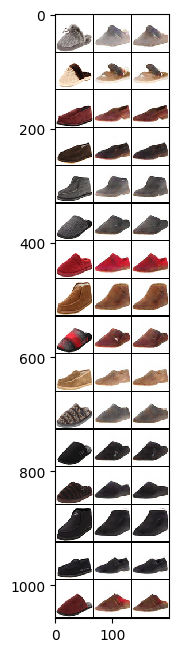

In [16]:
for x in dataloader:
    print(x.shape)
    x_features = alexnet.features(alexnet_norm(interpolate(denorm(x))))
    # Encode
    z = E(x)
    out_images = torch.stack((denorm(x),denorm(G(z))), dim=1)
    z.requires_grad_(True)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([z], lr=1e-3)
    
    for num_epoch in tqdm(range(100)):    
        outputs = G(z)
        # loss = criterion(outputs, x_)
        loss = criterion(x, outputs) + 0.002*criterion(x_features, alexnet.features(alexnet_norm(interpolate(denorm(outputs)))))
        z.grad = None
        loss.backward()
        optimizer.step()
        
    out_images = torch.cat((out_images,denorm(G(z)).unsqueeze(1)), dim=1)
    nrow = out_images.shape[1]
    out_images = out_images.reshape(-1, *x.shape[1:])
    print(out_images.shape)
    show(make_grid(out_images.detach(),nrow=nrow, normalize=False, scale_each=False, range=(0,1)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


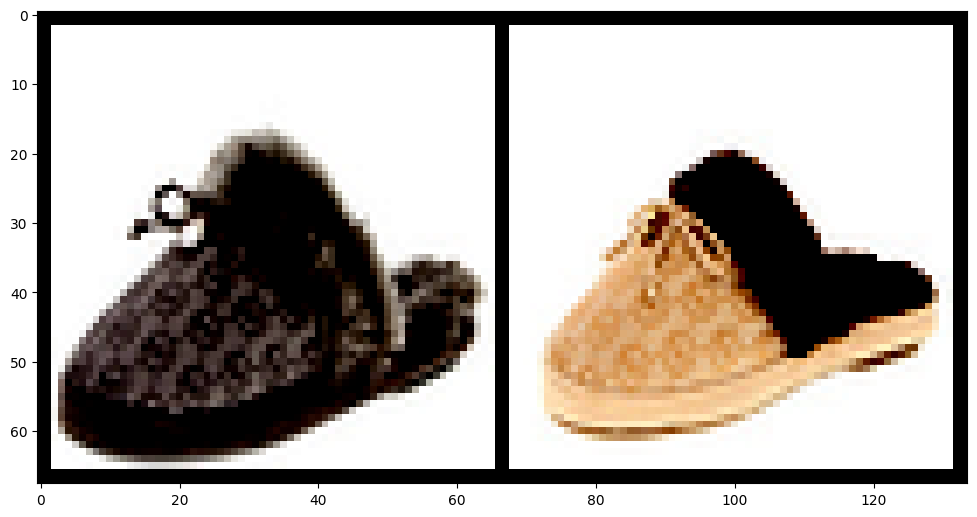

In [17]:

show(make_grid(torch.stack([x[0], x[1]],0),normalize=False, scale_each=False, range=(0,1)))
img1 = x[0].cpu().numpy()
img2 = x[1].cpu().numpy()

In [18]:
# ================ morph ===============

In [19]:
from numba import jit
from typing import List, Tuple

# Compute the L2 metric for the transportation cost. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,int64[:,:,:])",nopython=True)
def _generate_metric(height, width, grid):
    # Could probably inpmprove runtime using vectorized code
    C = np.zeros((height*width, height*width))
    i = 0
    j = 0
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    C[i,j] = np.square(grid[x1,y1,:] - grid[x2,y2,:]).sum()
                    j += 1
            j = 0
            i += 1
    return C

def generate_metric(im_size: Tuple[int]) -> np.ndarray:
    """
    Computes the Euclidean distances matrix
    
    Arguments:
        im_size {Tuple[int]} -- Size of the input image (height, width)
    
    Returns:
        np.ndarray -- distances matrix
    """
    grid = np.meshgrid(*[range(x) for x in im_size])
    grid = np.stack(grid,-1)
    return _generate_metric(im_size[0], im_size[1], grid)

# Find interpolation given the transportation plan. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,float64[:,:,:,:],float32)",nopython=True)
def generate_interpolation(height, width, plan, t):
    c = np.zeros((height+1, width+1))
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    new_loc_x = (1-t)*x1 + t*x2
                    new_loc_y = (1-t)*y1 + t*y2
                    p = new_loc_x - int(new_loc_x)
                    q = new_loc_y - int(new_loc_y)
                    c[int(new_loc_x),int(new_loc_y)] += (1-p)*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)] += p*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x),int(new_loc_y)+1] += (1-p)*q*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)+1] += p*q*plan[x1,y1,x2,y2]
    c = c[:height,:width] #* (I1_count*(1-t) + I2_count*t)
    return c

def sinkhorn(a: np.ndarray, b: np.ndarray, C: np.ndarray, height: int, width: int, 
             epsilon: float, threshold: float=1e-7) -> np.ndarray:
    """Computes the sinkhorn algorithm naively, using the CPU.
    
    Arguments:
        a {np.ndarray} -- the first distribution (image), normalized, and shaped to a vector of size height*width.
        b {np.ndarray} -- the second distribution (image), normalized, and shaped to a vector of size height*width.
        C {np.ndarray} -- the distances matrix
        height {int} -- image height
        width {int} -- image width
        epsilon {float} -- entropic regularization parameter
    
    Keyword Arguments:
        threshold {float} -- convergence threshold  (default: {1e-7})
    
    Returns:
        np.ndarray -- the entropic regularized transportation plan, pushing distribution a to b.
    """
    K = np.exp(-C/epsilon)
    v = np.random.randn(*a.shape)
    i = 0
    while True:
        u = a/(K.dot(v))
        v = b/(K.T.dot(u))
        i += 1
        if i % 50 == 0:
            convergence = np.square(np.sum(u.reshape(-1, 1) * K * v.reshape(1,-1), axis=1) - a).sum()
            if convergence < threshold:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} (Converged!)")
                break
            else:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} ( > {threshold})")

    P = u.reshape(-1, 1) * K * v.reshape(1,-1)
    P = P.reshape(height, width, height, width)
    return P

def sinkhorn_gpu(a: np.ndarray, b: np.ndarray, C: np.ndarray, height: int, width: int, 
                 epsilon: float, threshold: float=1e-7) -> np.ndarray:
    """Computes the sinkhorn algorithm using convolutional Wassestein distances (Solomon et al.), using the GPU.
    
    Arguments:
        a {np.ndarray} -- the first distribution (image), normalized, and shaped to a vector of size height*width.
        b {np.ndarray} -- the second distribution (image), normalized, and shaped to a vector of size height*width.
        C {np.ndarray} -- the distances matrix
        height {int} -- image height
        width {int} -- image width
        epsilon {float} -- entropic regularization parameter
    
    Keyword Arguments:
        threshold {float} -- convergence threshold  (default: {1e-7})
    
    Returns:
        np.ndarray -- the entropic regularized transportation plan, pushing distribution a to b.
    """
    K = torch.tensor(np.exp(-C/epsilon), dtype=torch.double).cuda()

    # Compute the kernel:
    kernel_size = max(int(epsilon*2),7)  # seems to be sufficient
    if kernel_size % 2 == 0:
        kernel_size += 1
    X = torch.tensor(range(kernel_size)).repeat(kernel_size,1)
    Y = torch.tensor(range(kernel_size)).reshape(-1,1).repeat(1,kernel_size)
    D = torch.zeros_like(X)
    for i in range(kernel_size):
        for j in range(kernel_size):
            D[i,j] = (X[i,j] - X[kernel_size//2,kernel_size//2])**2 + (Y[i,j] - Y[kernel_size//2,kernel_size//2])**2
    k = torch.exp(-D.type(torch.double)/epsilon).cuda().reshape(1,1,kernel_size,kernel_size)
    
    a = torch.tensor(a.reshape(1,1,height,width), dtype=torch.double).cuda()
    a /= a.sum()
    b = torch.tensor(b.reshape(1,1,height,width), dtype=torch.double).cuda()
    b /= b.sum()
    v = torch.ones_like(a) / k.sum()
    i = 0
    a_mask = a==0
    b_mask = b==0
    last_convergence = np.inf

    # Compute convolutional Sinkhorn
    while True:
        u = a/(torch.nn.functional.conv2d(v, k, padding=kernel_size//2))
        u[a_mask] = 0  # Fix 0/0 devision
        v = b/(torch.nn.functional.conv2d(u, k, padding=kernel_size//2))
        v[b_mask] = 0  # Fix 0/0 devision
        i += 1
        if i % 10 == 0:
            convergence = (torch.sum(u.reshape(-1, 1) * K * v.reshape(1,-1), dim=1) - a.reshape(-1)).pow(2).sum().item()  # Could probably be computed using convs as well
            print(i, convergence)
            if convergence < threshold or np.abs(last_convergence - convergence) < threshold:
                break
            last_convergence = convergence

    # Compute the trasportation plan
    P = u.reshape(-1, 1) * K * v.reshape(1,-1)  # Could probably be computed using convs as well
    P = P.reshape(height, width, height, width).cpu().numpy().astype(np.float)
    return P

def project_on_generator(G: Generator,
                         target_image: np.ndarray, E: Encoder, 
                         pix2pix_img_size: int=128) -> Tuple[np.ndarray, torch.Tensor]:
    """Projects the input image onto the manifold span by the GAN. It operates as follows:
    1. reshape and normalize the image
    2. run the encoder to obtain a latent vector
    3. run the DCGAN generator to obtain a low resolution image
    4. run the Pix2Pix model to obtain a high resulution image
    
    Arguments:
        G {Generator} -- DCGAN generator
        target_image {np.ndarray} -- The image to project
        E {Encoder} -- The DCGAN encoder
    
    Keyword Arguments:
        dcgan_img_size {int} -- Low resolution image size (default: {64})
        pix2pix_img_size {int} -- High resolution image size (default: {128})
    
    Returns:
        Tuple[np.ndarray, torch.Tensor] -- The projected high resolution image and the latent vector that was used to generate it.
    """
    # reshape and normalize image
    target_image = torch.Tensor(target_image).clamp(min=0)
    target_image = target_image / target_image.max()
    target_image = (target_image - 0.5) / 0.5

    # Run dcgan
    z = E(target_image.unsqueeze(0))
    out_image = G(z)
    out_image = denorm(out_image.detach()).clamp(0,1).cpu().numpy().reshape(3,-1,1)
    return out_image, z

def preprocess_Q(Q: np.ndarray, max_val: float=None, Q_counts: np.ndarray=None) -> Tuple[np.ndarray, float, np.ndarray]:
    """ Preprocess (normalize) input images before computing their barycenters
    
    Arguments:
        Q {np.ndarray} -- Input images. Every image should reshaped to a column in Q.
    
    Keyword Arguments:
        max_val {float} -- The maximum value. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
        Q_counts {np.ndarray} -- The sum of all the pixel values in each image. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
    
    Returns:
        Tuple[np.ndarray, float, np.ndarray] -- The normalized images the total maximum value and sum of pixels in each image
    """
    if max_val is None:
        max_val = Q.max()
    Q = max_val - Q
    if Q_counts is None:
        Q_counts = np.sum(Q, axis=1, keepdims=True)
    Q = Q / Q_counts
    return Q, max_val, Q_counts

In [20]:
img_size = (64, 64)
im1, im2 = (I.reshape(3,-1,1) for I in (img1, img2))
print(im1.shape)

(3, 4096, 1)


In [21]:
L = 9

print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon=20.0)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

print("Computing GAN projections...")
# Project OT results on GAN
GAN_projections = [project_on_generator(G, I, E) for I in out_OT]
GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

# Linearly interpolate GAN's latent space
if torch.cuda.is_available():
    noise1, noise2 = GAN_projections_noises[0].cuda(), GAN_projections_noises[-1].cuda()
else:
    noise1, noise2 = GAN_projections_noises[0], GAN_projections_noises[-1]
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    GAN_image = G((1-t)*noise1 + t*noise2)
    GAN_image = denorm(GAN_image.detach()).cpu().numpy().reshape(3,-1,1)
    out_GAN.append(GAN_image.clip(0,1))


Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 1.57E+00 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 2.44E-10 (Converged!)



Color space 2/3
Iteration 50. Sinkhorn convergence: 1.17E-01 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 3.81E-01 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 3.08E-09 (Converged!)



Color space 3/3
Iteration 50. Sinkhorn convergence: 1.62E-05 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 2.92E-08 (Converged!)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving results...


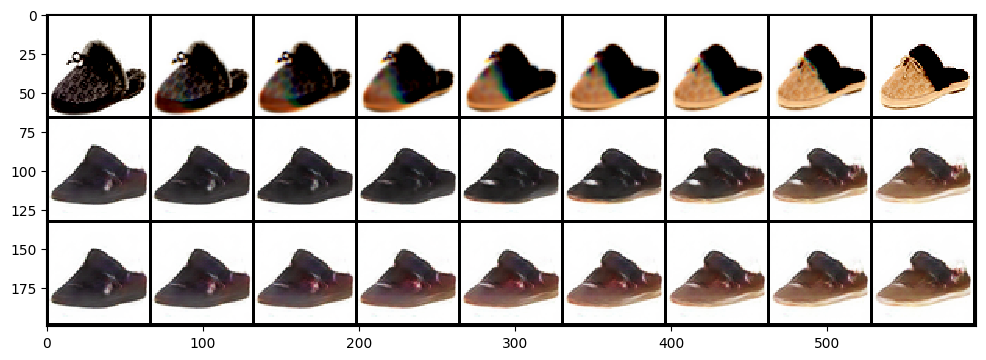

In [23]:
# Save results:
print("Saving results...")
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), nrow=L, normalize=False, scale_each=False, range=(0,1)))

In [ ]:
# ========= Flip shoe ===============

In [36]:
def flip_h(x):
    out = torch.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(x.shape[2]):
                out[i][j][k] = x[i][j][x.shape[2]-1-k]
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


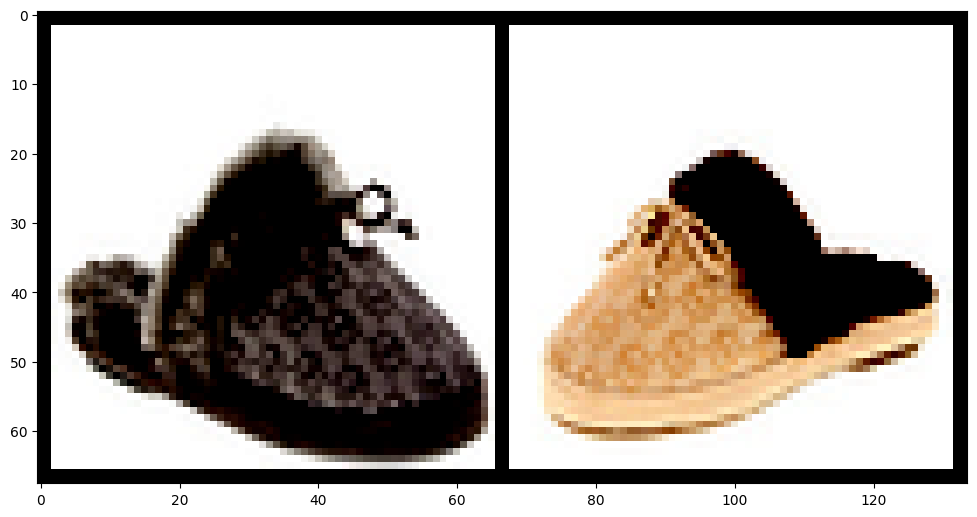

In [40]:
flip_x = flip_h(x[0]) 
show(make_grid(torch.stack([flip_x, x[1]],0),normalize=False, scale_each=False, range=(0,1)))
img1 = flip_x.cpu().numpy()
img2 = x[1].cpu().numpy()

In [41]:
img_size = (64, 64)
im1, im2 = (I.reshape(3,-1,1) for I in (img1, img2))
print(im1.shape)

L = 9

print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon=20.0)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

print("Computing GAN projections...")
# Project OT results on GAN
GAN_projections = [project_on_generator(G, I, E) for I in out_OT]
GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

# Linearly interpolate GAN's latent space
if torch.cuda.is_available():
    noise1, noise2 = GAN_projections_noises[0].cuda(), GAN_projections_noises[-1].cuda()
else:
    noise1, noise2 = GAN_projections_noises[0], GAN_projections_noises[-1]
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    GAN_image = G((1-t)*noise1 + t*noise2)
    GAN_image = denorm(GAN_image.detach()).cpu().numpy().reshape(3,-1,1)
    out_GAN.append(GAN_image.clip(0,1))


(3, 4096, 1)
Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 1.86E-07 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 5.33E-10 (Converged!)



Color space 2/3
Iteration 50. Sinkhorn convergence: 2.86E-07 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 1.12E-09 (Converged!)



Color space 3/3
Iteration 50. Sinkhorn convergence: 9.57E-08 (Converged!)



Computing GAN projections...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving results...


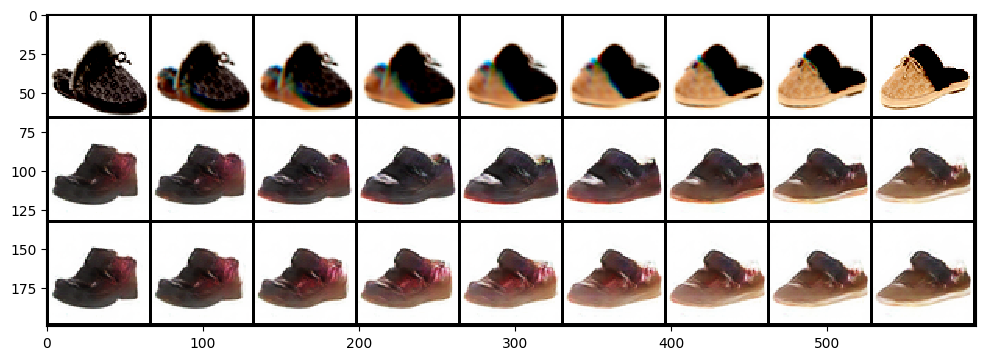

In [42]:
# Save results:
print("Saving results...")
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), nrow=L, normalize=False, scale_each=False, range=(0,1)))